In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("C:/Users/91809/Desktop/ARKS/05_ARKS_Early-Prediction-of-Autism-Disorder/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,Autistic.0.jpg,1
1,Autistic.1.jpg,1
2,Autistic.10.jpg,1
3,Autistic.100.jpg,1
4,Autistic.1000.jpg,1


In [5]:
df.tail()

,filename,category
2535,Non_Autistic.995.jpg,0
2536,Non_Autistic.996.jpg,0
2537,Non_Autistic.997.jpg,0
2538,Non_Autistic.998.jpg,0
2539,Non_Autistic.999.jpg,0


In [6]:
import os

# Directory path
directory_path = "C:/Users/91809/Desktop/ARKS/05_ARKS_Early-Prediction-of-Autism-Disorder/AutismDataset/train"

# Sample filename
sample = random.choice(filenames)  # Make sure sample contains the filename you want to load

# Create the full file path
file_path = os.path.join(directory_path, sample)

# Now load the image
image = load_img(file_path)


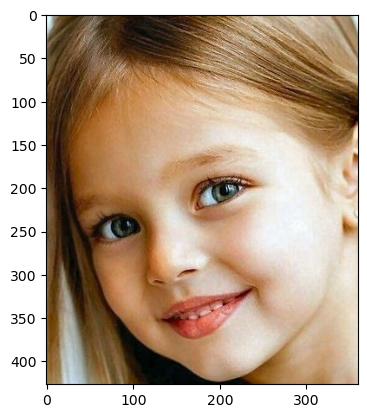

In [7]:
plt.imshow(image)

In [8]:
# CNN model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
# patience value
earlystop = EarlyStopping(patience=20)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
# Data preparation for training
df["category"] = df["category"].replace({0: 'Non_Autistic', 1: 'Autistic'}) 

In [14]:
# 80:20 ratio
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

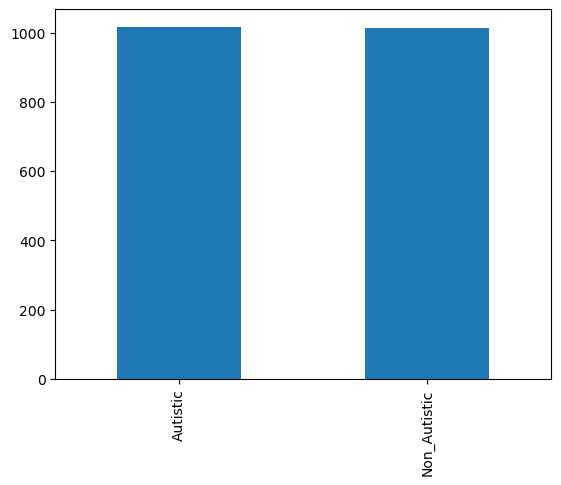

In [15]:
train_df['category'].value_counts().plot.bar()

<Axes: >

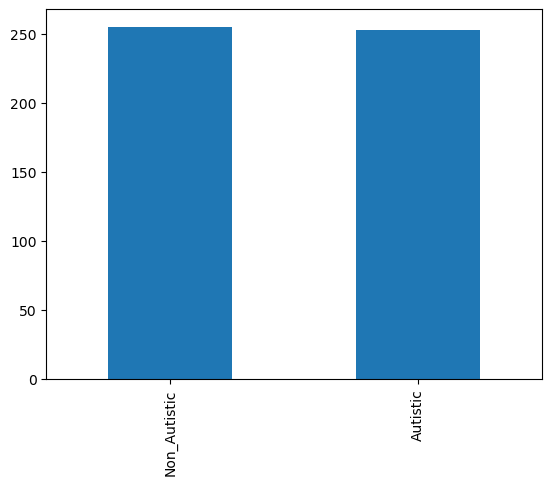

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

In [18]:
# Training Generator
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/91809/Desktop/ARKS/05_ARKS_Early-Prediction-of-Autism-Disorder/AutismDataset/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2032 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/91809/Desktop/ARKS/05_ARKS_Early-Prediction-of-Autism-Disorder/AutismDataset/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 508 validated image filenames belonging to 2 classes.


In [20]:
# Fit Model
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


C:\Users\91809\AppData\Local\Temp\ipykernel_16896\1475831346.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


127/127 [==============================] - 16s 82ms/step - loss: 1.1554 - accuracy: 0.6260 - val_loss: 1.4057 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 10s 80ms/step - loss: 0.8610 - accuracy: 0.6294 - val_loss: 2.0987 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 10s 80ms/step - loss: 0.7214 - accuracy: 0.6476 - val_loss: 0.9434 - val_accuracy: 0.5141 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 10s 80ms/step - loss: 0.6684 - accuracy: 0.6624 - val_loss: 0.6683 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 5/50
127/127 [==============================] - 10s 81ms/step - loss: 0.6409 - accuracy: 0.6718 - val_loss: 0.7454 - val_accuracy: 0.6048 - lr: 0.0010
Epoch 6/50
127/127 [==============================] - 11s 83ms/step - loss: 0.6002 - accuracy: 0.6811 - val_loss: 0.6543 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 7/50
127/127 [==============================] - 10s 81ms/step -

127/127 [==============================] - 10s 81ms/step - loss: 0.5091 - accuracy: 0.7549 - val_loss: 0.8486 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 22/50
127/127 [==============================] - 10s 80ms/step - loss: 0.5070 - accuracy: 0.7539 - val_loss: 0.5242 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 23/50
127/127 [==============================] - 10s 80ms/step - loss: 0.5013 - accuracy: 0.7702 - val_loss: 0.5253 - val_accuracy: 0.7641 - lr: 0.0010
Epoch 24/50
127/127 [==============================] - 10s 80ms/step - loss: 0.4868 - accuracy: 0.7702 - val_loss: 0.5220 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 25/50
127/127 [==============================] - 10s 81ms/step - loss: 0.4856 - accuracy: 0.7589 - val_loss: 0.5804 - val_accuracy: 0.7258 - lr: 0.0010
Epoch 26/50
127/127 [==============================] - 10s 80ms/step - loss: 0.4727 - accuracy: 0.7776 - val_loss: 0.7945 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 27/50
127/127 [==============================] - 10s 81ms/

127/127 [==============================] - 10s 82ms/step - loss: 0.4417 - accuracy: 0.7894 - val_loss: 0.6736 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 42/50
127/127 [==============================] - 10s 80ms/step - loss: 0.4682 - accuracy: 0.7820 - val_loss: 0.6733 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 43/50
127/127 [==============================] - 10s 81ms/step - loss: 0.4329 - accuracy: 0.7958 - val_loss: 0.6070 - val_accuracy: 0.7218 - lr: 0.0010
Epoch 44/50
127/127 [==============================] - 10s 80ms/step - loss: 0.4333 - accuracy: 0.8036 - val_loss: 0.5493 - val_accuracy: 0.7379 - lr: 0.0010


In [21]:
model.save_weights("model.h5")

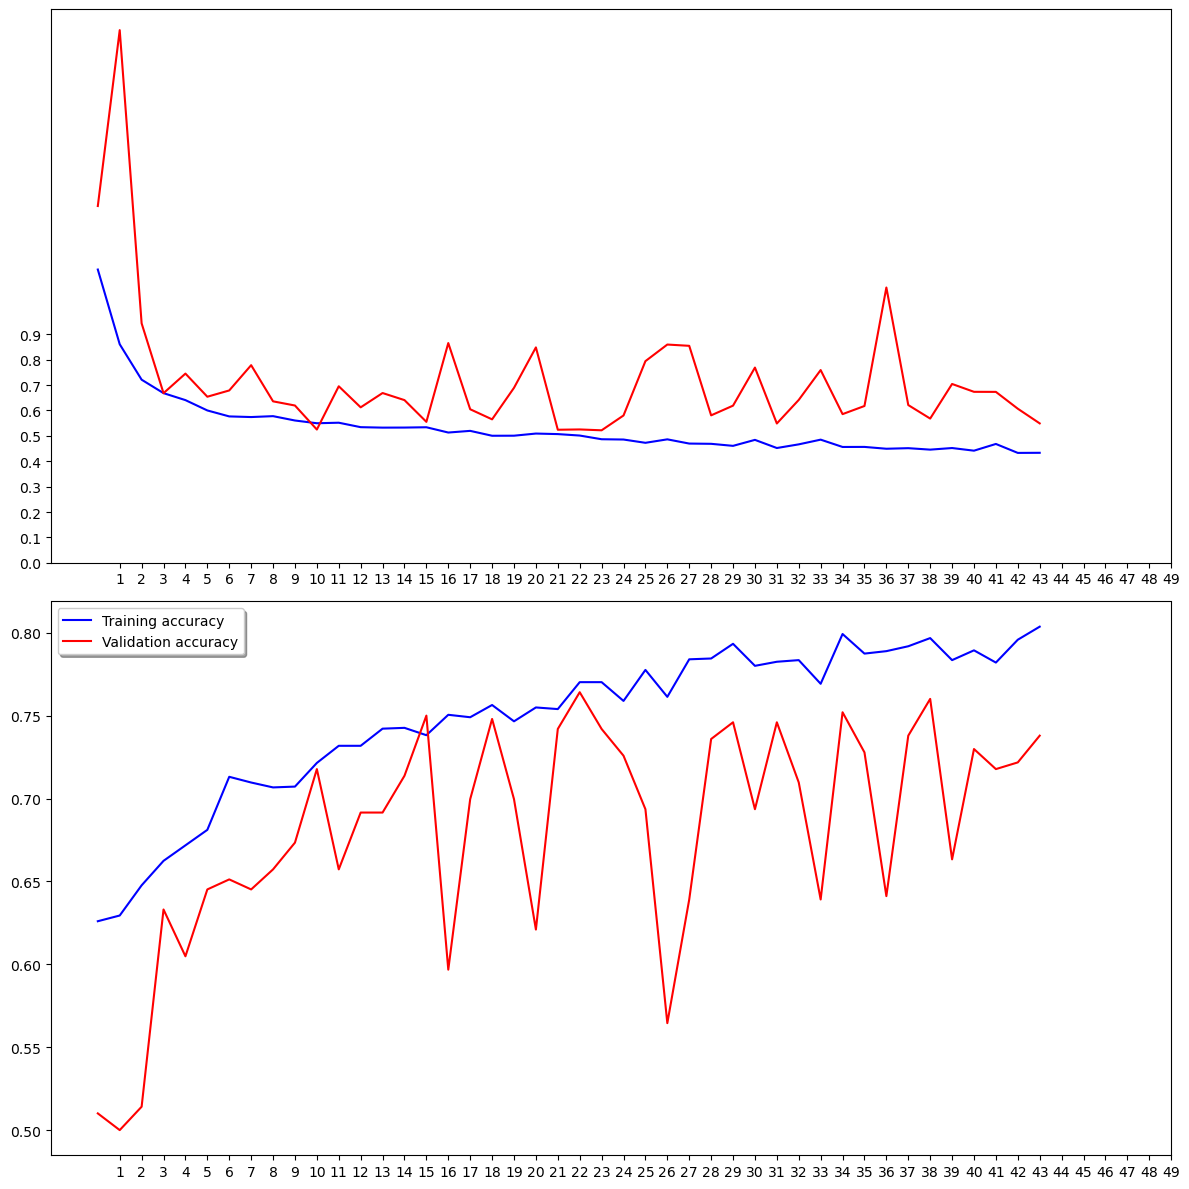

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [23]:
# Prepare Testing Data
test_filenames = os.listdir("C:/Users/91809/Desktop/ARKS/05_ARKS_Early-Prediction-of-Autism-Disorder/AutismDataset/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [24]:
print(nb_samples)

300


In [25]:
# Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/91809/Desktop/ARKS/05_ARKS_Early-Prediction-of-Autism-Disorder/AutismDataset/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [26]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\91809\AppData\Local\Temp\ipykernel_16896\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [27]:
test_df['category'] = np.argmax(predict, axis=-1)

In [28]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [29]:
test_df['category'] = test_df['category'].replace({ 'Autistic': 1, 'Non_Autistic': 0 })

<Axes: >

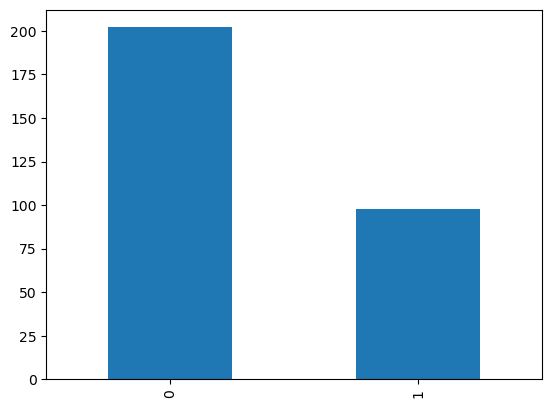

In [30]:
test_df['category'].value_counts().plot.bar()

In [33]:
model.save("newmodel.h5")

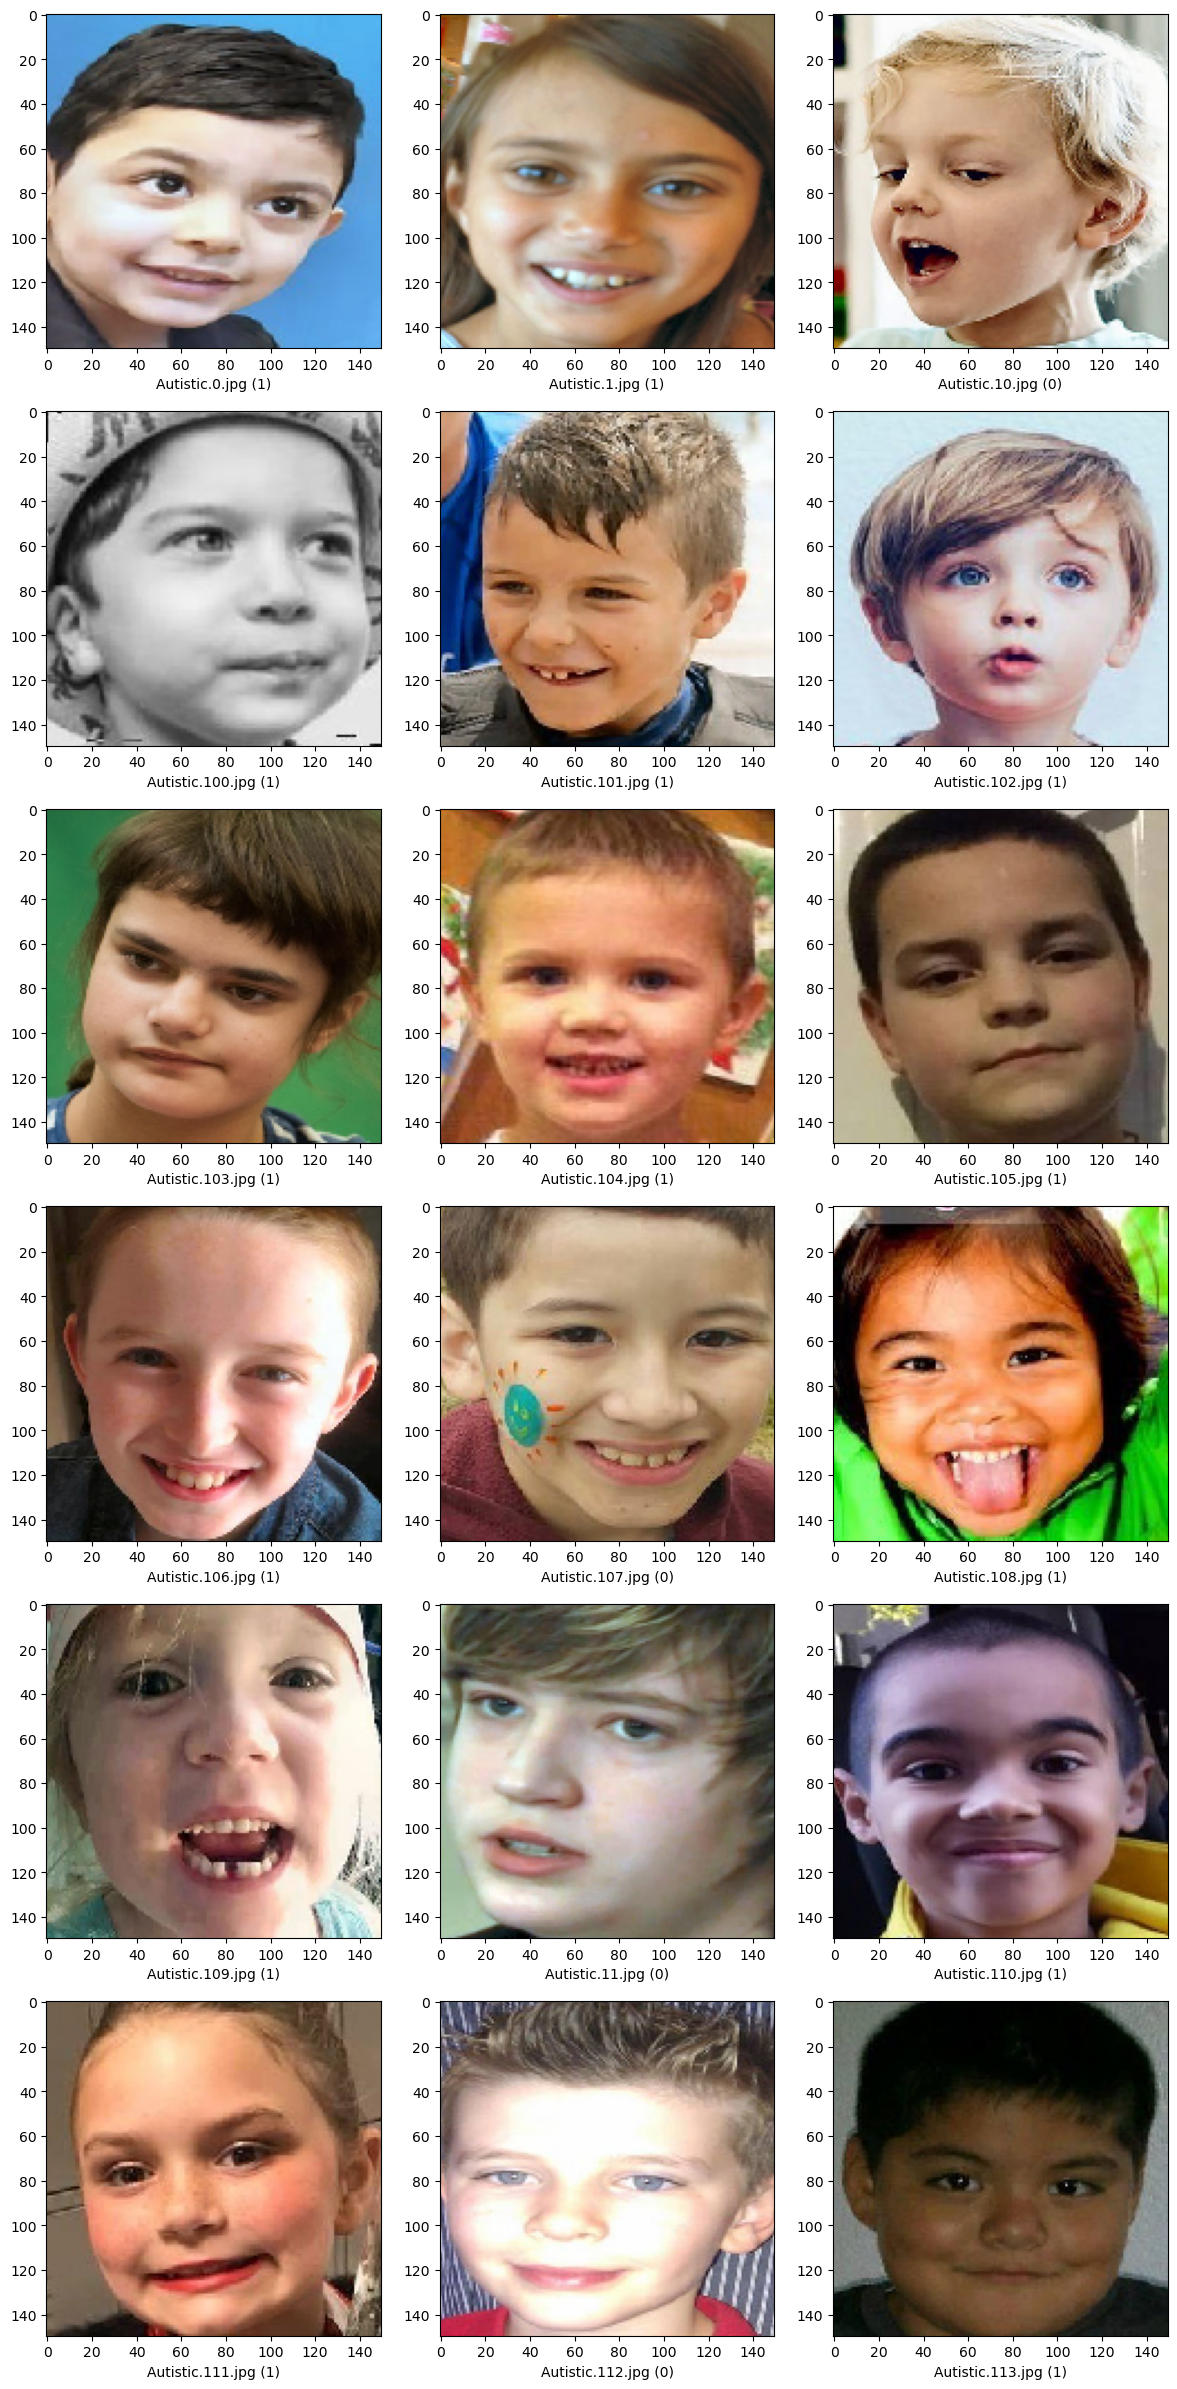

In [35]:
# Define the directory path and image size
directory_path = "C:/Users/91809/Desktop/ARKS/05_ARKS_Early-Prediction-of-Autism-Disorder/AutismDataset/test"
IMAGE_SIZE = (150, 150)  # Adjust the target size as needed

# Assuming you have a DataFrame named 'sample_test'
sample_test = test_df.head(18)

# Create a figure with subplots
plt.figure(figsize=(12, 24))

# Iterate through the DataFrame rows
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    
    # Construct the file path using os.path.join
    file_path = os.path.join(directory_path, filename)

    # Load the image
    img = load_img(file_path, target_size=IMAGE_SIZE)
    
    # Create a subplot
    plt.subplot(6, 3, index % 18 + 1)
    
    # Display the image and label
    plt.imshow(img)
    plt.xlabel(filename + ' (' + str(category) + ')')

# Ensure proper spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [36]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [37]:
pd.read_csv("submission.csv")

,id,label
0,Autistic,1
1,Autistic,1
2,Autistic,0
3,Autistic,1
4,Autistic,1
...,...,...
295,Non_Autistic,0
296,Non_Autistic,1
297,Non_Autistic,0
298,Non_Autistic,0
